In [22]:
import pandas as pd
import numpy as np

def import_data():
    data = pd.read_csv('https://supchains.com/wp-content/uploads/2021/07/norway_new_car_sales_by_make1.csv') #import data
    data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2) #create period column and account for padded zeros
    df = pd.pivot_table(data = data, values='Quantity', index = 'Make', columns = 'Period', aggfunc = 'sum', fill_value=0)
    return df

def datasets(df, x_len = 12, y_len = 1, test_loops = 12):
    D = df.values
    rows,periods = df.shape
    
    #training set creation
    loops = periods + 1 - x_len - y_len
    train = []
    for col in range(loops):
        train.append(D[:,col:col+x_len+y_len])
    train = np.vstack(train)
    X_train, Y_train = np.split(train, [-y_len], axis = 1)

    #test set creation
    if test_loops > 0:
        X_train, X_test = np.split(X_train, [-rows*test_loops], axis = 0)
        Y_train, Y_test = np.split(Y_train, [-rows*test_loops], axis = 0)
    else: #no test set: X_test is used to generate the future forecast
        X_test = D[:,-x_len:]
        Y_test = np.full((X_test.shape[0],y_len), np.nan) #dummy value

    #formatting required for scikit-learn
    if y_len == 1:
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()

    return(X_train, Y_train, X_test, Y_test)
    

def kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=''):
    df = pd.DataFrame(columns = ['MAE', 'RMSE', 'Bias'], index = ['Train', 'Test'])

    df.index.name = name

    df.loc['Train','MAE'] = 100*np.mean(abs(Y_train - Y_train_pred))/np.mean(Y_train)

    df.loc['Train','RMSE'] = 100*np.sqrt(np.mean((Y_train - Y_train_pred)**2))/np.mean(Y_train)

    df.loc['Train','Bias'] = 100*np.mean((Y_train - Y_train_pred))/np.mean(Y_train)

    df.loc['Test','MAE'] = 100*np.mean(abs(Y_test - Y_test_pred))/np.mean(Y_test)

    df.loc['Test','RMSE'] = 100*np.sqrt(np.mean((Y_test - Y_test_pred)**2))/np.mean(Y_test)

    df.loc['Test','Bias'] = 100*np.mean((Y_test - Y_test_pred))/np.mean(Y_test)

    df = df.astype(float).round(1)
    print(df)


 

In [23]:
df = import_data()
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=1, test_loops=12)

from sklearn.linear_model import LinearRegression
reg = LinearRegression() #create linear regression object
reg = reg.fit(X_train, Y_train) #fit it to training data

#create two predictions for the training and test sets
Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Regression')


X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=1, test_loops =0)
reg = LinearRegression()
reg = reg.fit(X_train, Y_train)
forecast = pd.DataFrame(data = reg.predict(X_test), index = df.index)
forecast.head()

             MAE  RMSE  Bias
Regression                  
Train       17.8  43.9   0.0
Test        17.8  43.7   1.6


0
Make                     
Alfa Romeo       6.187217
Aston Martin     1.032483
Audi           646.568622
BMW           1265.032834
Bentley          1.218092

In [81]:
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=1, test_loops =12)

In [25]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth = 5, min_samples_split = 15, min_samples_leaf = 5)

tree.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=15)

In [26]:
Y_train_pred = tree.predict(X_train)
Y_test_pred = tree.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name = 'Tree')

        MAE  RMSE  Bias
Tree                   
Train  18.1  43.4  -0.0
Test   21.1  52.6   3.2


In [27]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,6), dpi=300)
ax = fig.gca()
plot_tree(tree, fontsize = 3, feature_names = [f'M{x-12}' for x in range(12)], rounded = True, filled= True, ax=ax)
fig.savefig('Regression Tree.PNG')

In [31]:
#random forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

forest = RandomForestRegressor(bootstrap=True, max_samples=0.95, max_features=11, min_samples_leaf=18, max_depth=7)
forest.fit(X_train, Y_train)

Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forest')


         MAE  RMSE  Bias
Forest                  
Train   15.7  40.0   0.1
Test    18.3  47.2   3.7


In [49]:
#optimize forest model
max_depth = list(range(5,11)) + [None]
min_samples_split = range(5,20)
min_samples_leaf = range(2,15)

max_features = range(3,8)
bootstrap = [True]
max_samples = [.7,.8,.9,.95,1]

param_dist = {'max_depth': max_depth,
              'min_samples_split': min_samples_split, 
              'min_samples_leaf':min_samples_leaf, 
              'max_features':max_features, 
              'bootstrap':bootstrap, 
              'max_samples':max_samples}

forest = RandomForestRegressor(n_jobs=1, n_estimators=30)
forest_cv = RandomizedSearchCV(forest, param_dist, cv=6, n_jobs=-1, verbose=2, n_iter=400, scoring='neg_mean_absolute_error')
forest_cv.fit(X_train, Y_train)


Fitting 6 folds for each of 400 candidates, totalling 2400 fits
[CV] END bootstrap=True, max_depth=None, max_features=6, max_samples=1, min_samples_leaf=13, min_samples_split=13; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=6, max_samples=1, min_samples_leaf=13, min_samples_split=13; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=6, max_samples=1, min_samples_leaf=13, min_samples_split=13; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=5, max_samples=0.95, min_samples_leaf=7, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=5, max_samples=0.95, min_samples_leaf=7, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=5, max_samples=0.95, min_samples_leaf=7, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=6, max_samples=1, min_samples_leaf=13, min_samples_split=13; total time=   0.1s
[

RandomizedSearchCV(cv=6,
                   estimator=RandomForestRegressor(n_estimators=30, n_jobs=1),
                   n_iter=400, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [5, 6, 7, 8, 9, 10, None],
                                        'max_features': range(3, 8),
                                        'max_samples': [0.7, 0.8, 0.9, 0.95, 1],
                                        'min_samples_leaf': range(2, 15),
                                        'min_samples_split': range(5, 20)},
                   scoring='neg_mean_absolute_error', verbose=2)

In [50]:
# view tuned parameters for forest model
print('Tuned Forest Parameters:',forest_cv.best_params_)
print()
Y_train_pred = forest_cv.predict(X_train)
Y_test_pred = forest_cv.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forest optimized')

Tuned Forest Parameters: {'min_samples_split': 18, 'min_samples_leaf': 7, 'max_samples': 0.7, 'max_features': 5, 'max_depth': None, 'bootstrap': True}

                   MAE  RMSE  Bias
Forest optimized                  
Train             14.4  37.2  -0.1
Test              18.0  46.0   2.4


In [51]:
#update random forest to 200 estimators and view KPI
forest = RandomForestRegressor(n_estimators=200, n_jobs=-1, **forest_cv.best_params_)
forest = forest.fit(X_train, Y_train)

Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forestx200')

             MAE  RMSE  Bias
Forestx200                  
Train       14.3  37.0  -0.0
Test        17.6  45.4   2.9


<AxesSubplot:>

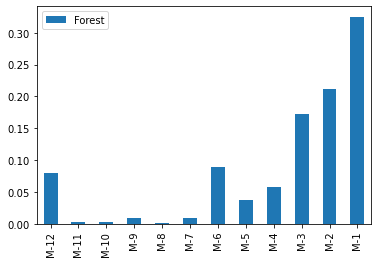

In [52]:
#significance bar chart

cols = X_train.shape[1]
features = [f'M-{cols-col}' for col in range(cols)]

data = forest.feature_importances_.reshape(-1,1)
imp = pd.DataFrame(data=data, index=features, columns=['Forest'])
imp.plot(kind='bar')

In [53]:
#extra tree model

from sklearn.ensemble import ExtraTreesRegressor
ETR = ExtraTreesRegressor(n_jobs=-1, n_estimators=200, min_samples_split=15, min_samples_leaf=4, max_samples=0.95, max_features=4, max_depth=8, bootstrap=True)
ETR.fit(X_train, Y_train)

Y_train_pred = ETR.predict(X_train)
Y_test_pred = ETR.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name = 'ETR')


        MAE  RMSE  Bias
ETR                    
Train  17.9  43.6   0.1
Test   19.1  47.5   3.2


In [54]:
#optimize ETR model
max_depth = list(range(6,13)) + [None]
min_samples_split = range(7,16)
min_samples_leaf = range(2,13)
max_features = range(5,13)

bootstrap = [True]
max_samples = [.7,.8,.9,.95,1]

param_dist = {'max_depth': max_depth,
              'min_samples_split': min_samples_split, 
              'min_samples_leaf':min_samples_leaf, 
              'max_features':max_features, 
              'bootstrap':bootstrap, 
              'max_samples':max_samples}

ETR = ExtraTreesRegressor(n_jobs=1, n_estimators=30)
ETR_cv = RandomizedSearchCV(ETR, param_dist, cv=5, n_jobs=-1, verbose=2, n_iter=400, scoring='neg_mean_absolute_error')
ETR_cv.fit(X_train, Y_train)


Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] END bootstrap=True, max_depth=12, max_features=5, max_samples=0.7, min_samples_leaf=9, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=12, max_features=5, max_samples=0.7, min_samples_leaf=9, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=12, max_features=5, max_samples=0.7, min_samples_leaf=9, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=11, max_samples=0.8, min_samples_leaf=8, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=11, max_samples=0.8, min_samples_leaf=8, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=11, max_samples=0.8, min_samples_leaf=8, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=11, max_samples=0.8, min_samples_leaf=8, min_samples_split=15; total time= 

RandomizedSearchCV(cv=5,
                   estimator=ExtraTreesRegressor(n_estimators=30, n_jobs=1),
                   n_iter=400, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [6, 7, 8, 9, 10, 11, 12,
                                                      None],
                                        'max_features': range(5, 13),
                                        'max_samples': [0.7, 0.8, 0.9, 0.95, 1],
                                        'min_samples_leaf': range(2, 13),
                                        'min_samples_split': range(7, 16)},
                   scoring='neg_mean_absolute_error', verbose=2)

In [55]:
#show parameters for optimized model
print('Tuned Forest Parameters:', ETR_cv.best_params_)
print()
Y_train_pred = ETR_cv.predict(X_train)
Y_test_pred = ETR_cv.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='ETR optimized')

Tuned Forest Parameters: {'min_samples_split': 8, 'min_samples_leaf': 3, 'max_samples': 0.7, 'max_features': 11, 'max_depth': 12, 'bootstrap': True}

                MAE  RMSE  Bias
ETR optimized                  
Train          14.1  35.9   0.1
Test           17.8  45.6   2.4


In [56]:
df = import_data()
forest_features = {'n_jobs':-1, 'n_estimators':200, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_samples':0.95, 'max_features': 0.3, 'max_depth':9, 'bootstrap': True}

forest = RandomForestRegressor(**forest_features)
ETR_features = {'n_jobs':-1, 'n_estimators':200, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_samples':0.9, 'max_features': 1.0, 'max_depth':12, 'bootstrap': True}
ETR = ExtraTreesRegressor(**ETR_features)
models = [('Forest',forest), ('ETR',ETR)]

In [60]:
def model_mae(model, X, Y):
    Y_pred = model.predict(X)
    mae = np.mean(np.abs(Y-Y_pred))/np.mean(Y)
    return mae

In [61]:
n_months = range(6,50,2)
results = []
for x_len in n_months:
    X_train, Y_train, X_test, Y_test = datasets(df, x_len=x_len)
    for name, model in models:
        model.fit(X_train, Y_train)
        mae_train = model_mae(model, X_train, Y_train)
        mae_test = model_mae(model, X_test, Y_test)
        results.append([name+'Train',mae_train, x_len])
        results.append([name+'Test',mae_test,x_len])

In [63]:
data = pd.DataFrame(results,columns=['Model','MAE%','Number of Months'])
data = data.set_index(['Number of Months', 'Model']).stack().unstack('Model')
data.index = data.index.droplevel(level=1)
data.index.name = 'Number of months'


Model
ETRTest        12
ETRTrain       40
ForestTest     30
ForestTrain    44
dtype: int64


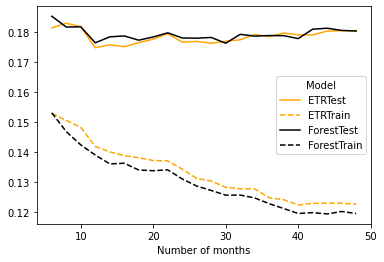

In [64]:
data.plot(color = ['orange']*2 + ['black']*2,style = ['-','--']*2)
print(data.idxmin())

In [65]:
#simple ada boost
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=100, learning_rate=0.25, loss='square')
ada = ada.fit(X_train,Y_train)

In [67]:
#view ada results
Y_train_pred = ada.predict(X_train)
Y_test_pred = ada.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name = 'AdaBoost')

           MAE  RMSE  Bias
AdaBoost                  
Train      7.3  15.8  -0.3
Test      18.1  46.6   3.7


In [68]:
#n_estimators = [100]
learning_rate = [0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35]
loss = ['square', 'exponential', 'linear']
param_dist = {#'n_estimators': n_estimators,
              'learning_rate': learning_rate, 
              'loss': loss}

In [69]:
results = []
for max_depth in range(2,18,2):
    ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth))
    ada_cv = RandomizedSearchCV(ada, param_dist, n_jobs=-1, cv=6, n_iter=20, scoring='neg_mean_absolute_error')
    ada_cv.fit(X_train, Y_train)

    print('Tuned AdaBoost Parameters:', ada_cv.best_params_)
    print('Results:',ada_cv.best_score_)
    results.append([ada_cv.best_score_,ada_cv.best_params_,max_depth])

Tuned AdaBoost Parameters: {'loss': 'linear', 'learning_rate': 0.01}
Results: -52.080968891602424
Tuned AdaBoost Parameters: {'loss': 'square', 'learning_rate': 0.005}
Results: -33.63716933042928
Tuned AdaBoost Parameters: {'loss': 'exponential', 'learning_rate': 0.01}
Results: -32.214022070874755
Tuned AdaBoost Parameters: {'loss': 'linear', 'learning_rate': 0.1}
Results: -31.922321366961608
Tuned AdaBoost Parameters: {'loss': 'exponential', 'learning_rate': 0.15}
Results: -31.939250864021147
Tuned AdaBoost Parameters: {'loss': 'square', 'learning_rate': 0.1}
Results: -31.907076192770436
Tuned AdaBoost Parameters: {'loss': 'square', 'learning_rate': 0.1}
Results: -31.99961452977219
Tuned AdaBoost Parameters: {'loss': 'square', 'learning_rate': 0.35}
Results: -32.06233696611035


In [71]:
results = pd.DataFrame(data=results, columns=['Score', 'Best Params', 'Max Depth'])
optimal = results['Score'].idxmax()
print(results.iloc[optimal])

Score                                        -31.907076
Best Params    {'loss': 'square', 'learning_rate': 0.1}
Max Depth                                            12
Name: 5, dtype: object


In [73]:
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8),n_estimators=100,learning_rate=0.005,loss='linear')
ada = ada.fit(X_train, Y_train)
Y_train_pred = ada.predict(X_train)
Y_test_pred = ada.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='AdaBoost optimized')

                     MAE  RMSE  Bias
AdaBoost optimized                  
Train                8.0  19.0   0.1
Test                19.1  49.4   5.7


In [82]:
from xgboost.sklearn import XGBRegressor
XGB = XGBRegressor(n_jobs=-1, max_depth=10, n_estimators=100, learning_rate=0.2)
XGB = XGB.fit(X_train, Y_train)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

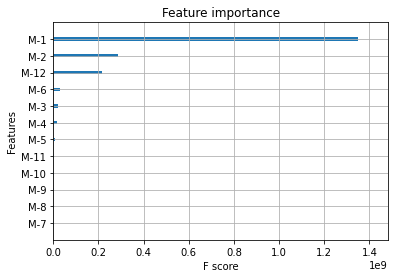

In [83]:
import xgboost as xgb
XGB.get_booster().feature_names = [f'M{x-12}' for x in range(12)]
xgb.plot_importance(XGB, importance_type='total_gain', show_values=False)